In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/data/tim/heronWorkspace/src")
sys.path.append("/data/tim/heronWorkspace/0_preProcessing")
sys.path.append("/data/tim/heronWorkspace/1_AE")
sys.path.append("/data/tim/heronWorkspace/2_postProcessing")
sys.path.append("/data/tim/heronWorkspace/")


from AEHeronModel import CAEHeron
from lightning.pytorch.callbacks import ModelSummary
from torchsummary import summary
import HeronImageLoader
from torch.utils.data import DataLoader, BatchSampler
from matplotlib import pyplot as plt
import lightning.pytorch as pl
from lightning.pytorch.tuner import Tuner
import pandas as pd
from lightning.pytorch.loggers import CSVLogger
from models import MLPBasic, CAEBigBottleneck, CAESmallBottleneckWithLinear, MLPBasicHeatMap, CAEV1
import numpy as np
import torch.nn.functional as F
import torch
from torchvision.transforms import GaussianBlur
from PIL import Image, ImageFilter
import random
from scipy.stats import loguniform
from ClassifierDatasets import DatasetThreeConsecutive, UnNormalize
# from torchmetrics.image import StructuralSimilarityIndexMeasure
from skimage.metrics import structural_similarity as ssim
import seaborn as sns
from sklearn.model_selection import ParameterSampler
from scipy.stats import loguniform
import functorch
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve
from PostProcessingHelper import MinFilter, PostProcess, CheckPoints
import glob
from pathlib import Path
import os


colors = [
    "#32829C",
    "#E38538",
    "#51AC8C",
    "#D94841",
    "#7A5C96"
]
sns.set_palette(sns.color_palette(colors))
sns.set_style("whitegrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Global vs Camera Specific Model

always on fixed params in the postprocessing

## on SBU4
SBU4 is a camera distinct from training set of the AE's. Here we get two insights:
- How well does a model adapting to other cameras?
- And we get a measure about how much is the AE part and how much the postprocessing.

In [21]:
# wanted checkpoints
path = '/data/tim/heronWorkspace/logs/BasicCAE1/' # use your path
ckptList = []
for i in range(2, 6):
    ckptList.append(glob.glob(os.path.join(path, f"version_{i}", "checkpoints", "*.ckpt"))[-1])


loaderParams = dict(
    lblValidationMode = "Manual",
    balanced = True,
    anomalyObviousness = "all",
    distinctCAETraining = False,
    colorMode = "RGB",
    random_state = 1,
    set = "all"
)
startState = dict(
    cameras = ["SBU4"],#["NEN1", "SBU3"], #["GBU1", "GBU4", "KBU2", "PSU1", "PSU2", "PSU3", "SBU3", "SGN1"],
    balanced = True,
    distinctCAETraining = False,
    gaussianFilterSize = 5,
    gaussianFilterSigma = 5,
    filter = "MinFilter", #["MinFilter", "GaussianFilter"]
    minFilterKernelSize = 4,
    zeroThreshold = 0.2, # uniform dist on loc, loc+scale -> uniform(loc, scale) #threshold for zeroing out the image
    # sumThreshold = 50.9,
    lossFn = "L1"
)

# checkPointGlobal = "/data/tim/heronWorkspace/logs/BasicCAE1/version_3/checkpoints/epoch=14-step=40770.ckpt"
# checkPointSBU3 = "/data/tim/heronWorkspace/logs/BasicCAE1/version_12/checkpoints/epoch=24-step=4825.ckpt"

 # uniform dist on loc, loc+scale -> uniform(loc, scale) #threshold for zeroing out the image


sumValsListAll = []
lblValsListAll = []

for ckpt in [CheckPoints.bestGlobal, CheckPoints.bestSBU3]:
    sumVals, lblVals = PostProcess.computeSum(params=startState, loaderParams=loaderParams, checkPoint = ckpt)
    sumValsListAll.append(sumVals)
    lblValsListAll.append(lblVals)

loaderParams["anomalyObviousness"] = "obvious"
sumValsListObv = []
lblValsListObv= []
for ckpt in [checkPointGlobal, checkPointSBU3]:
    sumVals, lblVals = PostProcess.computeSum(params=startState, loaderParams=loaderParams, checkPoint = ckpt)
    sumValsListObv.append(sumVals)
    lblValsListObv.append(lblVals)
    
print("successfully computed sumVals and lblVals")


Length of dataset: 740
{'cameras': ['SBU4'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSize': 5, 'gaussianFilterSigma': 5, 'filter': 'MinFilter', 'minFilterKernelSize': 4, 'zeroThreshold': 0.2, 'lossFn': 'L1'}
Length of dataset: 740
{'cameras': ['SBU4'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSize': 5, 'gaussianFilterSigma': 5, 'filter': 'MinFilter', 'minFilterKernelSize': 4, 'zeroThreshold': 0.2, 'lossFn': 'L1'}
Length of dataset: 186
{'cameras': ['SBU4'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSize': 5, 'gaussianFilterSigma': 5, 'filter': 'MinFilter', 'minFilterKernelSize': 4, 'zeroThreshold': 0.2, 'lossFn': 'L1'}
Length of dataset: 186
{'cameras': ['SBU4'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSize': 5, 'gaussianFilterSigma': 5, 'filter': 'MinFilter', 'minFilterKernelSize': 4, 'zeroThreshold': 0.2, 'lossFn': 'L1'}
successfully computed sumVals and lblVals


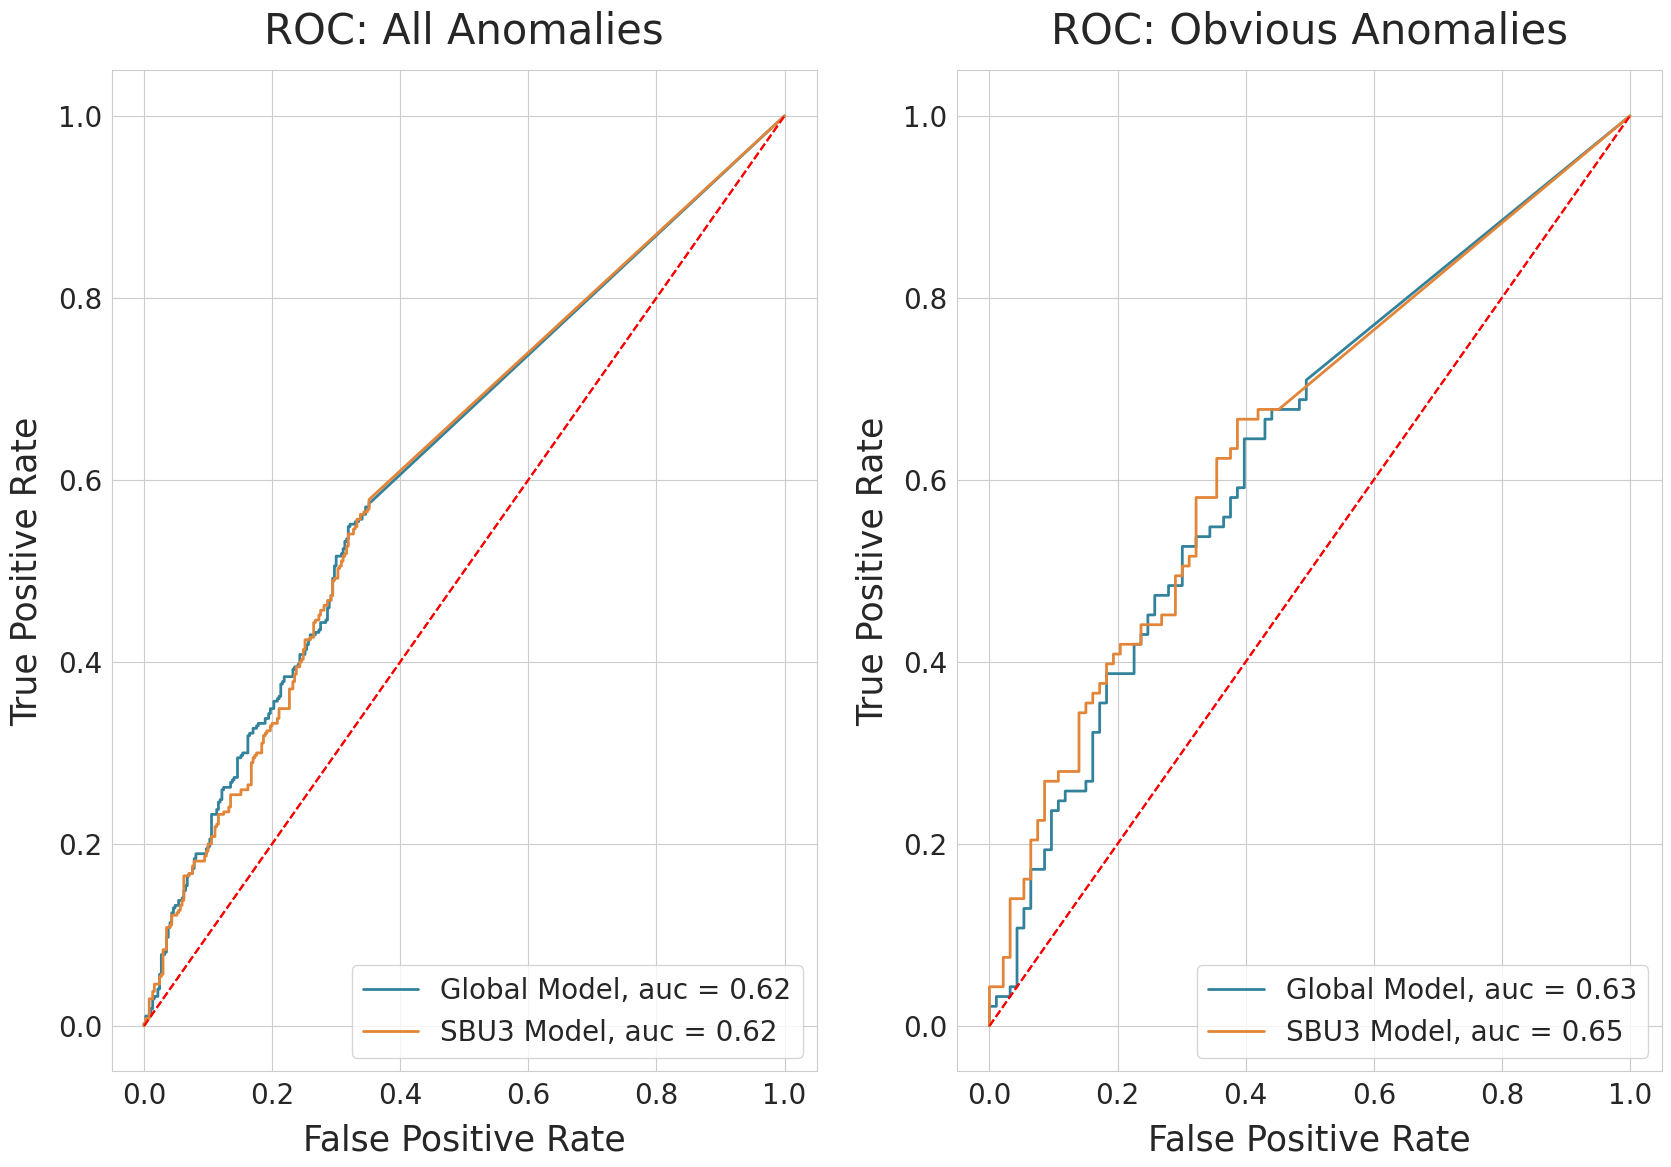

In [26]:
# fig, ax = plt.subplots(1, 2, figsize = (16,11)) 
fig, ax = plt.subplots(1, 2, figsize = (20,13)) 

for i, (sumVals, lblVals) in enumerate(zip(sumValsListAll, lblValsListAll)):
    fpr, tpr, thresholds = roc_curve(lblVals, sumVals)
    roc_auc = roc_auc_score(lblVals, sumVals)
    if i == 0:
        ax[0].plot(fpr, tpr, label=f'Global Model, auc = {roc_auc:0.2f}', linewidth=2)
    else:
        ax[0].plot(fpr, tpr, label=f'SBU3 Model, auc = {roc_auc:0.2f}', linewidth=2)

    ax[0].plot([0, 1], [0, 1],'r--') 
    ax[0].set_title('ROC: All Anomalies', size=30, pad=20) 
    ax[0].legend(loc="lower right")



for i, (sumVals, lblVals) in enumerate(zip(sumValsListObv, lblValsListObv)):
    fpr, tpr, thresholds = roc_curve(lblVals, sumVals)
    roc_auc = roc_auc_score(lblVals, sumVals)
    if i == 0:
        ax[1].plot(fpr, tpr, label=f'Global Model, auc = {roc_auc:0.2f}', linewidth=2)
    else:
        ax[1].plot(fpr, tpr, label=f'SBU3 Model, auc = {roc_auc:0.2f}', linewidth=2)

    ax[1].plot([0, 1], [0, 1],'r--') 
    ax[1].set_title('ROC: Obvious Anomalies', size=30, pad=20) 
    ax[1].legend(loc="lower right")

for a in ax:
    a.set_xlabel(xlabel='False Positive Rate', fontsize=25, labelpad=10)
    a.set_ylabel(ylabel='True Positive Rate', fontsize=25, labelpad=10)
    a.tick_params(labelsize=20)
    a.legend(fontsize='20', loc="lower right")

plt.show()

## on SBU3
one camera is specifically trained for the camera, one is globally trained but with SBU3 as well

- This gives an insight if it's better to choose specific models trimmed on the cam or if we can train global ones.


In [6]:

loaderParams = dict(
    lblValidationMode = "Manual",
    balanced = True,
    anomalyObviousness = "all",
    distinctCAETraining = False,
    colorMode = "RGB",
    random_state = 1,
    set = "all"
)
startState = dict(
    cameras = ["SBU3"],#["NEN1", "SBU3"], #["GBU1", "GBU4", "KBU2", "PSU1", "PSU2", "PSU3", "SBU3", "SGN1"],
    balanced = True,
    distinctCAETraining = False,
    gaussianFilterSize = 5,
    gaussianFilterSigma = 5,
    filter = "MinFilter", #["MinFilter", "GaussianFilter"]
    minFilterKernelSize = 4,
    zeroThreshold = 0.2, # uniform dist on loc, loc+scale -> uniform(loc, scale) #threshold for zeroing out the image
    # sumThreshold = 50.9,
    lossFn = "L1"
)

 # uniform dist on loc, loc+scale -> uniform(loc, scale) #threshold for zeroing out the image


sumValsListAll = []
lblValsListAll = []

for ckpt in [CheckPoints.bestGlobal, CheckPoints.bestSBU3]:
    sumVals, lblVals = PostProcess.computeSum(params=startState, loaderParams=loaderParams, checkPoint = ckpt)
    sumValsListAll.append(sumVals)
    lblValsListAll.append(lblVals)

loaderParams["anomalyObviousness"] = "obvious"
sumValsListObv = []
lblValsListObv= []
for ckpt in [CheckPoints.bestGlobal, CheckPoints.bestSBU3]:
    sumVals, lblVals = PostProcess.computeSum(params=startState, loaderParams=loaderParams, checkPoint = ckpt)
    sumValsListObv.append(sumVals)
    lblValsListObv.append(lblVals)
    
print("successfully computed sumVals and lblVals")


Length of dataset: 192
{'cameras': ['SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSize': 5, 'gaussianFilterSigma': 5, 'filter': 'MinFilter', 'minFilterKernelSize': 4, 'zeroThreshold': 0.2, 'lossFn': 'L1'}
Length of dataset: 192
{'cameras': ['SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSize': 5, 'gaussianFilterSigma': 5, 'filter': 'MinFilter', 'minFilterKernelSize': 4, 'zeroThreshold': 0.2, 'lossFn': 'L1'}
Length of dataset: 60
{'cameras': ['SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSize': 5, 'gaussianFilterSigma': 5, 'filter': 'MinFilter', 'minFilterKernelSize': 4, 'zeroThreshold': 0.2, 'lossFn': 'L1'}
Length of dataset: 60
{'cameras': ['SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSize': 5, 'gaussianFilterSigma': 5, 'filter': 'MinFilter', 'minFilterKernelSize': 4, 'zeroThreshold': 0.2, 'lossFn': 'L1'}
successfully computed sumVals and lblVals


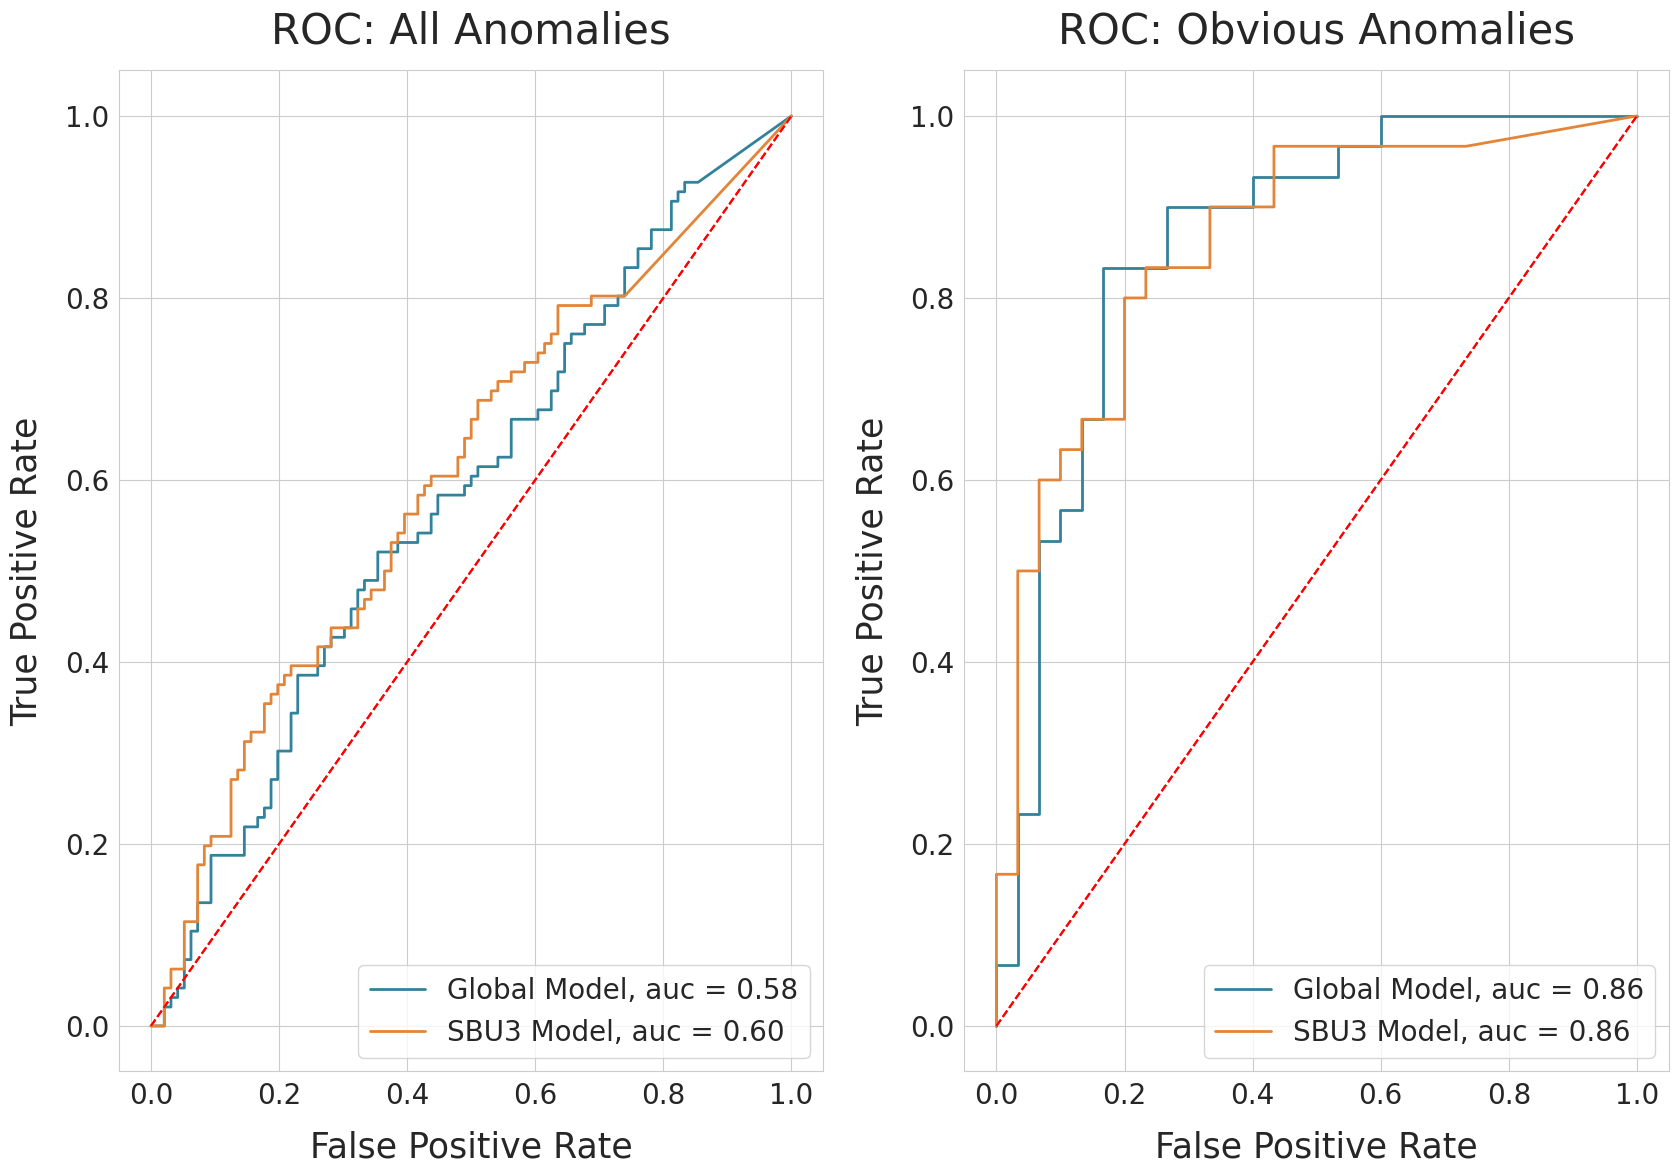

In [20]:
fig, ax = plt.subplots(1, 2, figsize = (20,13)) 
for i, (sumVals, lblVals) in enumerate(zip(sumValsListAll, lblValsListAll)):
    fpr, tpr, thresholds = roc_curve(lblVals, sumVals)
    roc_auc = roc_auc_score(lblVals, sumVals)
    if i == 0:
        ax[0].plot(fpr, tpr, label=f'Global Model, auc = {roc_auc:0.2f}', linewidth=2)
    else:
        ax[0].plot(fpr, tpr, label=f'SBU3 Model, auc = {roc_auc:0.2f}', linewidth=2)

    ax[0].plot([0, 1], [0, 1],'r--') 
   
    ax[0].set_title('ROC: All Anomalies', size=30, pad=20) 
    # ax[0].legend(fontsize='15', loc="lower right")

    # ax[0].legend(loc="lower right")



for i, (sumVals, lblVals) in enumerate(zip(sumValsListObv, lblValsListObv)):
    fpr, tpr, thresholds = roc_curve(lblVals, sumVals)
    roc_auc = roc_auc_score(lblVals, sumVals)
    if i == 0:
        ax[1].plot(fpr, tpr, label=f'Global Model, auc = {roc_auc:0.2f}', linewidth=2)
    else:
        ax[1].plot(fpr, tpr, label=f'SBU3 Model, auc = {roc_auc:0.2f}', linewidth=2)

    ax[1].plot([0, 1], [0, 1],'r--') 
 
    ax[1].set_title('ROC: Obvious Anomalies', size=30, pad=20) 


for a in ax:
    a.set_xlabel(xlabel='False Positive Rate', fontsize=20, labelpad=15)
    a.set_ylabel(ylabel='True Positive Rate', fontsize=20, labelpad=15)
    a.tick_params(labelsize=20)
    a.legend(fontsize='20', loc="lower right")

plt.show()

This cam has a lot of anomalies that are small such as herons far away or small birds ... that'y why the performance on all the anomalies are rather bad.

## on respective datasets

In [27]:

loaderParams = dict(
    lblValidationMode = "Manual",
    balanced = True,
    anomalyObviousness = "all",
    distinctCAETraining = False,
    colorMode = "RGB",
    random_state = 1,
    set = "all"
)
startState = dict(
    cameras = ["SBU3"],#["NEN1", "SBU3"], #["GBU1", "GBU4", "KBU2", "PSU1", "PSU2", "PSU3", "SBU3", "SGN1"],
    balanced = True,
    distinctCAETraining = False,
    gaussianFilterSize = 5,
    gaussianFilterSigma = 5,
    filter = "MinFilter", #["MinFilter", "GaussianFilter"]
    minFilterKernelSize = 4,
    zeroThreshold = 0.2, # uniform dist on loc, loc+scale -> uniform(loc, scale) #threshold for zeroing out the image
    # sumThreshold = 50.9,
    lossFn = "L1"
)

checkPointGlobal = "/data/tim/heronWorkspace/logs/BasicCAE1/version_3/checkpoints/epoch=14-step=40770.ckpt"
checkPointSBU3 = "/data/tim/heronWorkspace/logs/BasicCAE1/version_12/checkpoints/epoch=24-step=4825.ckpt"

 # uniform dist on loc, loc+scale -> uniform(loc, scale) #threshold for zeroing out the image


sumValsListAll = []
lblValsListAll = []

for i, ckpt in enumerate([checkPointGlobal, checkPointSBU3]):
    if i == 0:
        startState["cameras"] = ["GBU1", "GBU4", "KBU2", "PSU1", "PSU2", "PSU3", "SBU3", "SGN1"]
    else:
        startState["cameras"] = ["SBU3"]

    sumVals, lblVals = PostProcess.computeSum(params=startState, loaderParams=loaderParams, checkPoint = ckpt)
    sumValsListAll.append(sumVals)
    lblValsListAll.append(lblVals)

loaderParams["anomalyObviousness"] = "obvious"
sumValsListObv = []
lblValsListObv= []
for i, ckpt in enumerate([checkPointGlobal, checkPointSBU3]):
    if i == 0:
        startState["cameras"] = ["GBU1", "GBU4", "KBU2", "PSU1", "PSU2", "PSU3", "SBU3", "SGN1"]
    else:
        startState["cameras"] = ["SBU3"]
        
    sumVals, lblVals = PostProcess.computeSum(params=startState, loaderParams=loaderParams, checkPoint = ckpt)
    sumValsListObv.append(sumVals)
    lblValsListObv.append(lblVals)
    
print("successfully computed sumVals and lblVals")


/data/tim/heronWorkspace/manuallyClassified/manuallyClassifiedSGN1.csv not found
you must manually classify some images first to use the manual validation mode
skipping the camera: SGN1
Length of dataset: 450
{'cameras': ['GBU1', 'GBU4', 'KBU2', 'PSU1', 'PSU2', 'PSU3', 'SBU3', 'SGN1'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSize': 5, 'gaussianFilterSigma': 5, 'filter': 'MinFilter', 'minFilterKernelSize': 4, 'zeroThreshold': 0.2, 'lossFn': 'L1'}
Length of dataset: 192
{'cameras': ['SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSize': 5, 'gaussianFilterSigma': 5, 'filter': 'MinFilter', 'minFilterKernelSize': 4, 'zeroThreshold': 0.2, 'lossFn': 'L1'}
/data/tim/heronWorkspace/manuallyClassified/manuallyClassifiedSGN1.csv not found
you must manually classify some images first to use the manual validation mode
skipping the camera: SGN1
Length of dataset: 112
{'cameras': ['GBU1', 'GBU4', 'KBU2', 'PSU1', 'PSU2', 'PSU3', 'SBU3', 'SGN1'], 'balanced

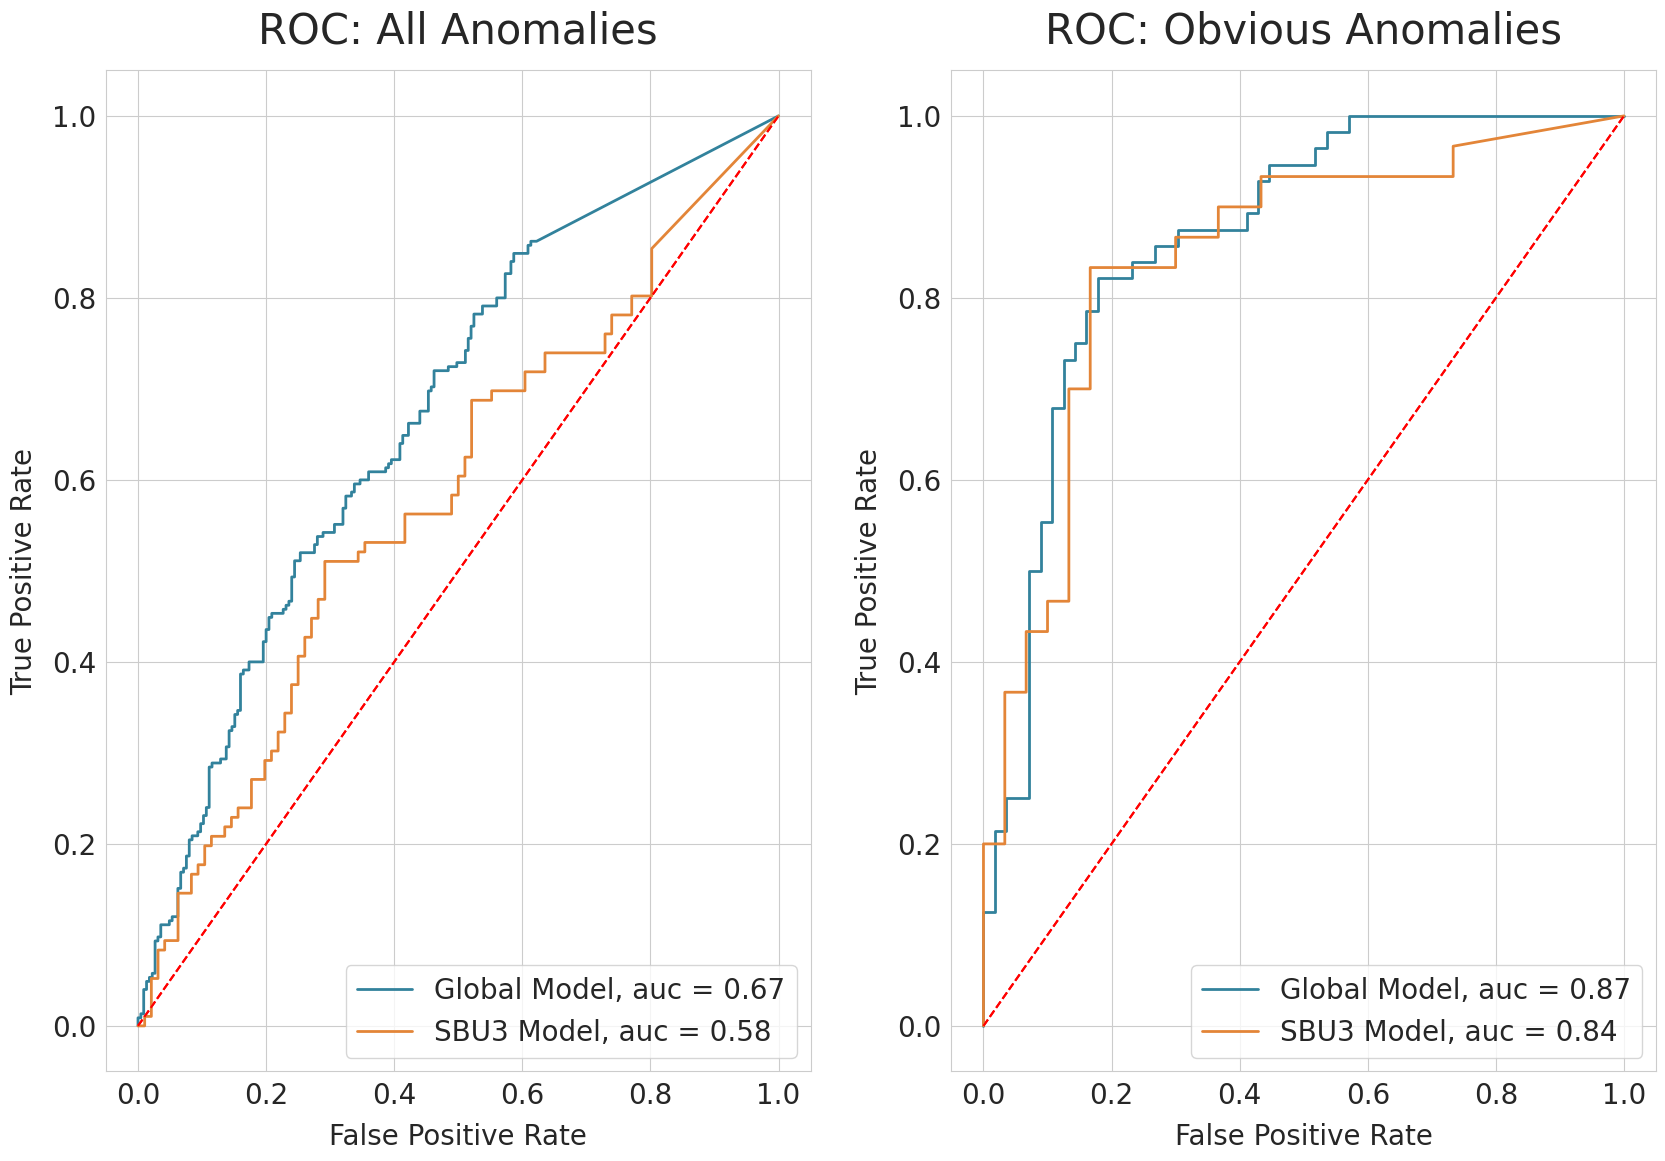

In [28]:
fig, ax = plt.subplots(1, 2, figsize = (20,13)) 
for i, (sumVals, lblVals) in enumerate(zip(sumValsListAll, lblValsListAll)):
    fpr, tpr, thresholds = roc_curve(lblVals, sumVals)
    roc_auc = roc_auc_score(lblVals, sumVals)
    if i == 0:
        ax[0].plot(fpr, tpr, label=f'Global Model, auc = {roc_auc:0.2f}', linewidth=2)
    else:
        ax[0].plot(fpr, tpr, label=f'SBU3 Model, auc = {roc_auc:0.2f}', linewidth=2)

    ax[0].plot([0, 1], [0, 1],'r--') 
   
    ax[0].set_title('ROC: All Anomalies', size=30, pad=20) 
    # ax[0].legend(fontsize='15', loc="lower right")

    # ax[0].legend(loc="lower right")



for i, (sumVals, lblVals) in enumerate(zip(sumValsListObv, lblValsListObv)):
    fpr, tpr, thresholds = roc_curve(lblVals, sumVals)
    roc_auc = roc_auc_score(lblVals, sumVals)
    if i == 0:
        ax[1].plot(fpr, tpr, label=f'Global Model, auc = {roc_auc:0.2f}', linewidth=2)
    else:
        ax[1].plot(fpr, tpr, label=f'SBU3 Model, auc = {roc_auc:0.2f}', linewidth=2)

    ax[1].plot([0, 1], [0, 1],'r--') 
 
    ax[1].set_title('ROC: Obvious Anomalies', size=30, pad=20) 


for a in ax:
    a.set_xlabel(xlabel='False Positive Rate', fontsize=20, labelpad=10)
    a.set_ylabel(ylabel='True Positive Rate', fontsize=20, labelpad=10)
    a.tick_params(labelsize=20)
    a.legend(fontsize='20', loc="lower right")

plt.show()

# both all data

In [29]:

loaderParams = dict(
    lblValidationMode = "Manual",
    balanced = True,
    anomalyObviousness = "all",
    distinctCAETraining = False,
    colorMode = "RGB",
    random_state = 1,
    set = "all"
)
startState = dict(
    cameras = ["GBU1", "GBU4", "KBU2", "PSU1", "PSU2", "PSU3", "SBU3", "SGN1"],
    balanced = True,
    distinctCAETraining = False,
    gaussianFilterSize = 5,
    gaussianFilterSigma = 5,
    filter = "MinFilter", #["MinFilter", "GaussianFilter"]
    minFilterKernelSize = 4,
    zeroThreshold = 0.2, # uniform dist on loc, loc+scale -> uniform(loc, scale) #threshold for zeroing out the image
    # sumThreshold = 50.9,
    lossFn = "L1"
)

checkPointGlobal = "/data/tim/heronWorkspace/logs/BasicCAE1/version_3/checkpoints/epoch=14-step=40770.ckpt"
checkPointSBU3 = "/data/tim/heronWorkspace/logs/BasicCAE1/version_12/checkpoints/epoch=24-step=4825.ckpt"

 # uniform dist on loc, loc+scale -> uniform(loc, scale) #threshold for zeroing out the image


sumValsListAll = []
lblValsListAll = []

for ckpt in [checkPointGlobal, checkPointSBU3]:
    sumVals, lblVals = PostProcess.computeSum(params=startState, loaderParams=loaderParams, checkPoint = ckpt)
    sumValsListAll.append(sumVals)
    lblValsListAll.append(lblVals)

loaderParams["anomalyObviousness"] = "obvious"
sumValsListObv = []
lblValsListObv= []
for ckpt in [checkPointGlobal, checkPointSBU3]:
    sumVals, lblVals = PostProcess.computeSum(params=startState, loaderParams=loaderParams, checkPoint = ckpt)
    sumValsListObv.append(sumVals)
    lblValsListObv.append(lblVals)
    
print("successfully computed sumVals and lblVals")


/data/tim/heronWorkspace/manuallyClassified/manuallyClassifiedSGN1.csv not found
you must manually classify some images first to use the manual validation mode
skipping the camera: SGN1
Length of dataset: 450
{'cameras': ['GBU1', 'GBU4', 'KBU2', 'PSU1', 'PSU2', 'PSU3', 'SBU3', 'SGN1'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSize': 5, 'gaussianFilterSigma': 5, 'filter': 'MinFilter', 'minFilterKernelSize': 4, 'zeroThreshold': 0.2, 'lossFn': 'L1'}
/data/tim/heronWorkspace/manuallyClassified/manuallyClassifiedSGN1.csv not found
you must manually classify some images first to use the manual validation mode
skipping the camera: SGN1
Length of dataset: 450
{'cameras': ['GBU1', 'GBU4', 'KBU2', 'PSU1', 'PSU2', 'PSU3', 'SBU3', 'SGN1'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSize': 5, 'gaussianFilterSigma': 5, 'filter': 'MinFilter', 'minFilterKernelSize': 4, 'zeroThreshold': 0.2, 'lossFn': 'L1'}
/data/tim/heronWorkspace/manuallyClassified/manuallyCl

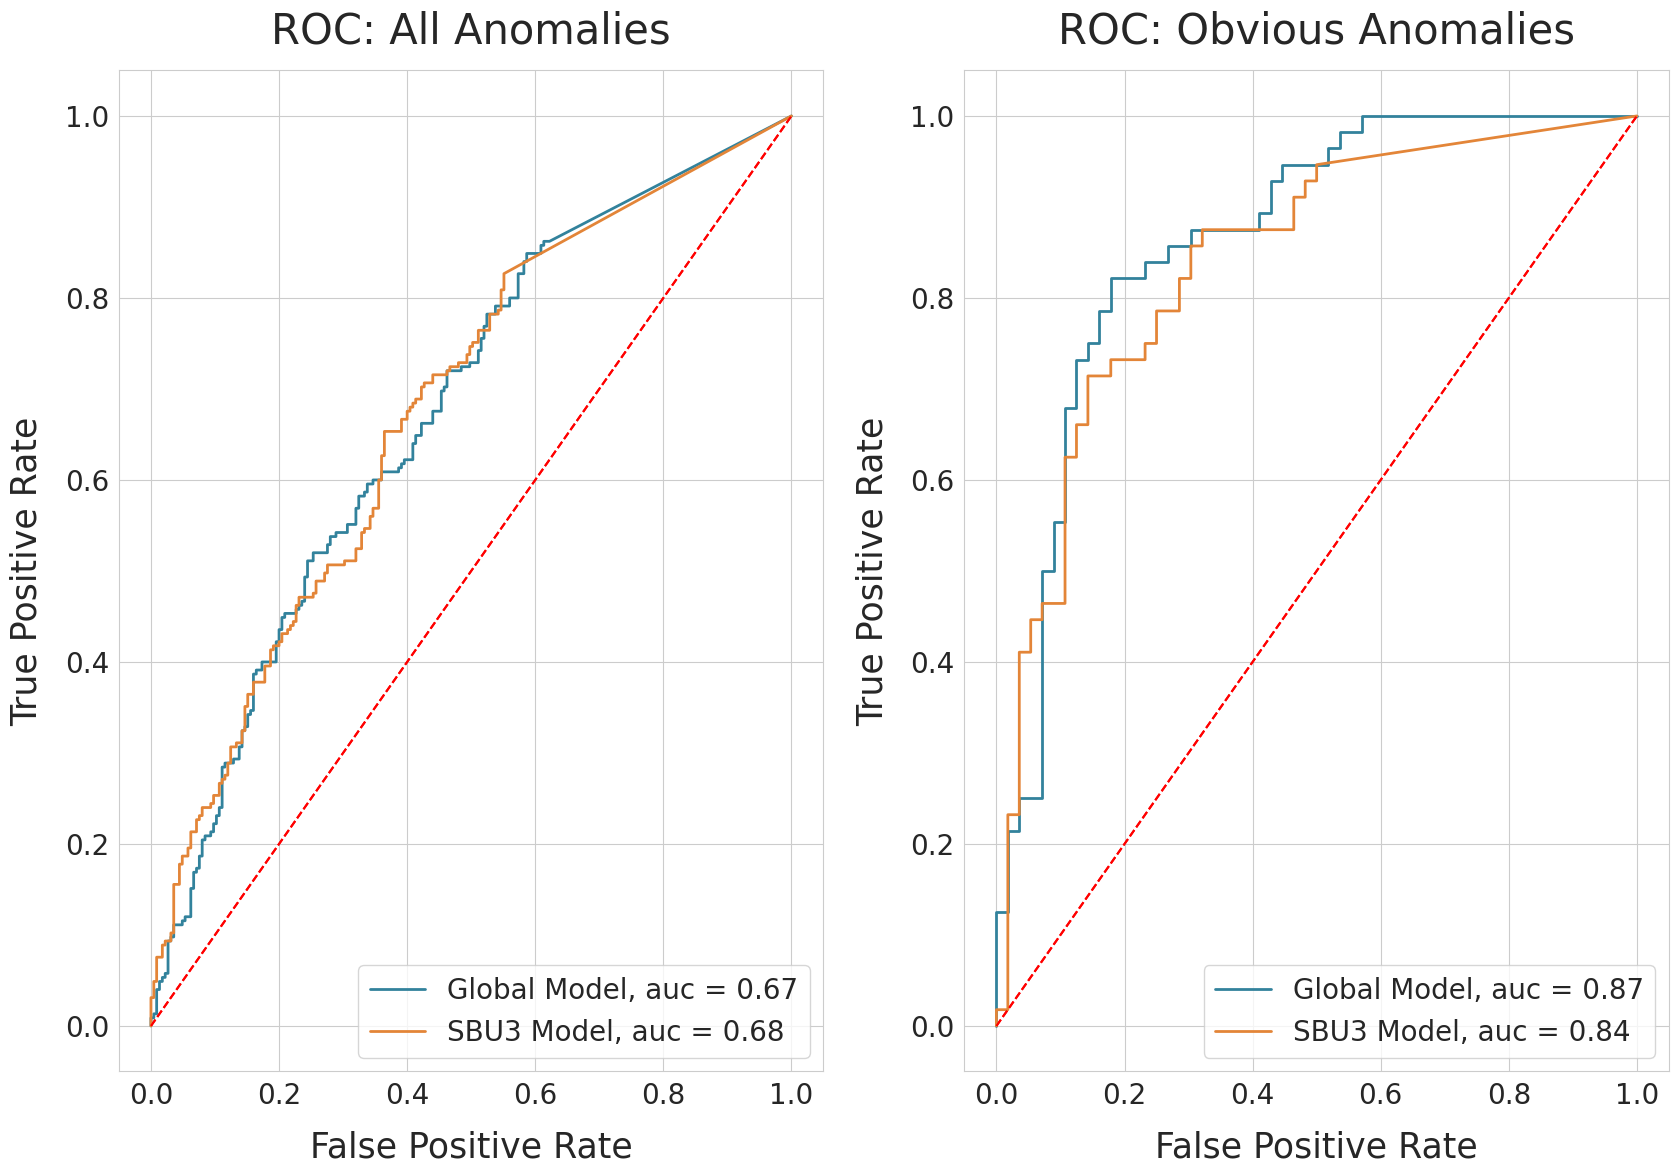

In [30]:
fig, ax = plt.subplots(1, 2, figsize = (20,13)) 
for i, (sumVals, lblVals) in enumerate(zip(sumValsListAll, lblValsListAll)):
    fpr, tpr, thresholds = roc_curve(lblVals, sumVals)
    roc_auc = roc_auc_score(lblVals, sumVals)
    if i == 0:
        ax[0].plot(fpr, tpr, label=f'Global Model, auc = {roc_auc:0.2f}', linewidth=2)
    else:
        ax[0].plot(fpr, tpr, label=f'SBU3 Model, auc = {roc_auc:0.2f}', linewidth=2)

    ax[0].plot([0, 1], [0, 1],'r--') 
   
    ax[0].set_title('ROC: All Anomalies', size=30, pad=20) 
    # ax[0].legend(fontsize='15', loc="lower right")

    # ax[0].legend(loc="lower right")



for i, (sumVals, lblVals) in enumerate(zip(sumValsListObv, lblValsListObv)):
    fpr, tpr, thresholds = roc_curve(lblVals, sumVals)
    roc_auc = roc_auc_score(lblVals, sumVals)
    if i == 0:
        ax[1].plot(fpr, tpr, label=f'Global Model, auc = {roc_auc:0.2f}', linewidth=2)
    else:
        ax[1].plot(fpr, tpr, label=f'SBU3 Model, auc = {roc_auc:0.2f}', linewidth=2)

    ax[1].plot([0, 1], [0, 1],'r--') 
 
    ax[1].set_title('ROC: Obvious Anomalies', size=30, pad=20) 


for a in ax:
    a.set_xlabel(xlabel='False Positive Rate', fontsize=25, labelpad=15)
    a.set_ylabel(ylabel='True Positive Rate', fontsize=25, labelpad=15)
    a.tick_params(labelsize=20)
    a.legend(fontsize='20', loc="lower right")

plt.show()